In [1]:
from pyrep import PyRep
from pyrep.robots.arms.panda import Panda
from pyrep.robots.end_effectors.panda_gripper import PandaGripper
import numpy as np
from matplotlib import pyplot as plt

from mpl_toolkits.mplot3d import Axes3D
from IPython import display

from pyrep.objects.shape import Shape
from pyrep.const import PrimitiveShape

from scipy.spatial.transform import Rotation as R

import math
from copy import copy

In [2]:
pr = PyRep()
pr.launch('../../assets/scene_panda.ttt', headless=True)

In [3]:
agent = Panda()
gripper = PandaGripper()

In [4]:
home_pos = agent.get_tip().get_position()
home_orient = agent.get_tip().get_orientation()

In [5]:
def grasp(grip=False):
    if grip:
        pos = 0.1
    else:
        pos = 0.9
    actuated = False
    ims = []
    states = []
    while not actuated:
        actuated = gripper.actuate(pos,0.1)
        im0,im1 = get_image()
        ims.append((im0,im1))
        states.append(agent.get_tip().get_pose())
    return ims,states

In [6]:
def move_above_object(object_name='',offset=0.05):
    pos = agent.get_object(object_name).get_position()
    pos[2] = pos[2] + offset
    orient = [-np.pi,0,np.pi/2]

    path = agent.get_path(position=pos,euler=orient)

    done = False
    ims = []
    states = []
    while not done:
        done = path.step()
        im0,im1 = get_image()
        ims.append((im0,im1))
        states.append(agent.get_tip().get_pose())
    return ims,states

In [7]:
def clear_view():

    path = agent.get_path(position=home_pos,euler=home_orient)

    done = False
    ims = []
    states = []
    while not done:
        done = path.step()
        im0,im1 = get_image()
        ims.append((im0,im1))
        states.append(agent.get_tip().get_pose())
    return ims,states

In [8]:
def get_image():
    cam = agent.get_object('Vision_sensor_front')
    im0 = cam.capture_rgb()
    cam1 = agent.get_object('Vision_sensor')
    im1 = cam1.capture_rgb()
    pr.step()
    return im0, im1

In [9]:
from itertools import permutations 
obj_id_list = []
for r in range(2,7):
    obj_id_list = obj_id_list + list(permutations(range(0, 6),r=r))

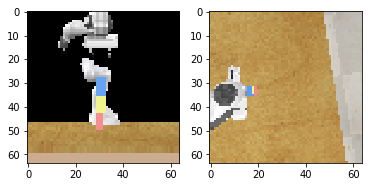

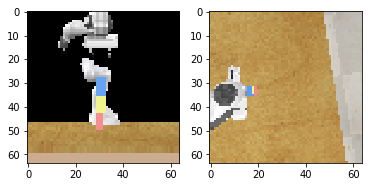

In [10]:
for run in range(len(obj_id_list)):

    pr.start()

    obj_ids = obj_id_list[run]

    grasp(grip=False)
    gripper.release()
    ims = []
    states = []
    for j in range(1,len(obj_ids)):
        object_name = 'Cuboid%d'%obj_ids[j]
        i,s = move_above_object(object_name,offset=0.08)
        ims = ims + i
        states = states + s
        i,s = move_above_object(object_name,offset=0)
        ims = ims + i
        states = states + s
        i,s = grasp(grip=True)
        ims = ims + i
        states = states + s
        gripper.grasp(agent.get_object(object_name))
        i,s = move_above_object(object_name,offset=0.08)
        ims = ims + i
        states = states + s
        object_name = 'Cuboid%d'%obj_ids[j-1]
        i,s = move_above_object(object_name,offset=0.15)
        ims = ims + i
        states = states + s
        i,s = move_above_object(object_name,offset=0.05)
        ims = ims + i
        states = states + s
        i,s = grasp(grip=False)
        ims = ims + i
        states = states + s
        gripper.release()
        i,s = move_above_object(object_name,offset=0.2)
        ims = ims + i
        states = states + s
        #clear_view()

        plt.cla()
        plt.clf()
        plt.subplot(1,2,1)
        plt.imshow(ims[-1][0])
        plt.subplot(1,2,2)
        plt.imshow(ims[-1][1])
        display.clear_output(wait=True)
        display.display(plt.gcf())

    pr.stop()

    np.save('../../demos/perms_subsets/ims_%04d.npy'%run, np.stack(ims)[-1][0])
    np.save('../../demos/perms_subsets/order_%04d.npy'%run, obj_ids)

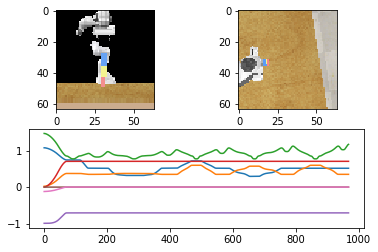

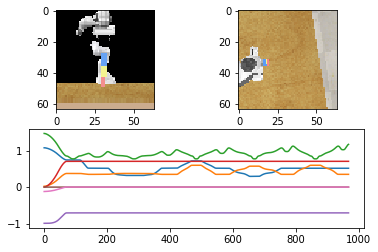

In [11]:
for i,im in enumerate(ims):
    plt.cla()
    plt.clf()
    plt.subplot(2,2,1)
    plt.imshow(im[0])
    plt.subplot(2,2,2)
    plt.imshow(im[1])
    plt.subplot(2,1,2)
    plt.plot(np.vstack(states)[0:i,:])
    display.clear_output(wait=True)
    display.display(plt.gcf())

In [12]:
pr.shutdown()